In [1]:
import geoviews as gv
import holoviews as hv
from holoviews.operation.datashader import datashade, dynspread
from colorcet import kgy
from matplotlib import cm

import pyspark
from pyspark import SparkConf, SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import dask.dataframe as dd
import multiprocessing as mp

import pandas as pd
from datashader.utils import lnglat_to_meters as webm

from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

import pandas as pd
from folium import Map
from folium.plugins import HeatMap

import datashader as ds

from colorcet import fire
import datashader.transfer_functions as tf

In [2]:
# Make sure the spaces are deleted from the trip data set before running this
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load("/Users/kallejanssen/Desktop/Computer Science/Large Scale Data Engineering/Ass_2/FOIL_2010_UNZIPPED.nosync/trip_data_2.csv")

In [3]:
df = df.select('medallion','pickup_datetime','dropoff_datetime','trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')
df.show()

+----------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
| medallion|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+----------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|2010001858|2010-02-01 00:00:00|2010-02-01 00:11:11|              670|          2.6|      -73.935448|      40.696869|        -73.95575|       40.676968|
|2010007438|2010-02-01 00:00:00|2010-02-01 00:20:29|             1228|          5.6|      -73.989326|      40.730759|       -73.953323|       40.665535|
|2010008871|2010-02-01 00:00:00|2010-02-01 00:09:18|              558|          1.2|      -74.005188|      40.733292|       -73.990608|       40.725056|
|2010009615|2010-02-01 00:00:01|2010-02-01 00:06:05|              363|          1.

In [4]:
for_map = pd.read_csv('FOIL_2010_UNZIPPED.nosync/trip_data_2.csv', nrows=600000)


In [5]:
# These figures are commented due to size restrictions by Github, instead I included an image directly below all large interactive figures.

# NYC_map = Map(location=[40.696869, -73.935448], zoom_start=8, )

# NYC_data = HeatMap(
#     list(zip(for_map.pickup_latitude.values, for_map.pickup_longitude.values)),
#     min_opacity=0.5,
#     radius=3, 
#     blur=5, 
#     max_zoom=1,
# )

# NYC_map.add_child(NYC_data)

![title](img/pic1.png)

In [6]:
# import folium
# from folium.plugins import MarkerCluster
# import pandas as pd
 
# coords = (40.696869, -73.935448)
# NYC_data = pd.read_csv('FOIL_2010_UNZIPPED.nosync/trip_data_2.csv', nrows=6000)
  
# map1 = folium.Map(location=coords, zoom_start=12)
    
# map1.add_child(MarkerCluster(locations=list(zip(NYC_data['pickup_latitude'], NYC_data['pickup_longitude']))))


# display(map1)

![title](img/pic2.png)

In [7]:
# source: https://towardsdatascience.com/large-scale-visualizations-and-mapping-with-datashader-d465f5c47fb5

df = pd.read_csv('FOIL_2010_UNZIPPED.nosync/trip_data_2.csv')

df.loc[:, 'easting'], df.loc[:, 'northing'] = webm(df['pickup_longitude'],df['pickup_latitude'])


/Users/kallejanssen/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kallejanssen/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df = df[['hack_license','pickup_datetime','pickup_longitude','pickup_latitude','easting','northing']]

In [9]:
sw = webm(-74.1,40.6)
ne = webm(-73.8,40.9)
Coords = zip(sw, ne)

In [10]:
dask_df = dd.from_pandas(df, npartitions=mp.cpu_count())
dask_df = dask_df.compute()

In [11]:
background = "black"
export = partial(export_image, background = "black", export_path="export")
cm1 = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
cvs = ds.Canvas(500, 500, *Coords)
agg = cvs.points(dask_df, 'easting', 'northing')

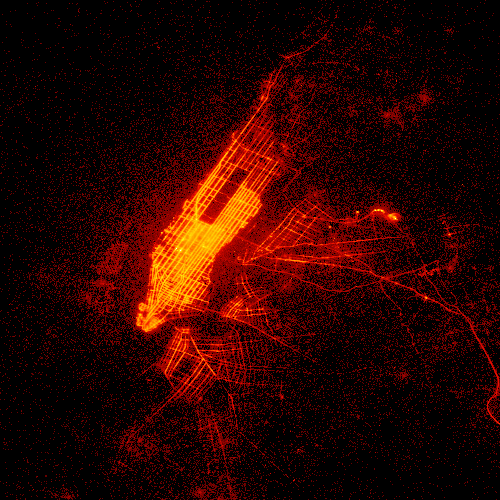

In [13]:
export(tf.shade(agg, cmap = cm1(fire,0.2), how='log'),"NYC")

In [15]:
# hv.extension('bokeh', width=95)

# %opts RGB     [width=1200 height=682 xaxis=None yaxis=None show_grid=False] 
# %opts Shape (fill_alpha=0 line_width=1.5) [apply_ranges=False tools=['tap']] 
# %opts Points [apply_ranges=False] WMTS (alpha=0.5)
# %opts Overlay [width=900 height=525 xaxis=None yaxis=None]

# url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png"
# geomap = gv.WMTS(url)
# points = hv.Points(gv.Dataset(dask_df, kdims=['easting', 'northing']))
# biz_cat = dynspread(datashade(points, color_key=kgy, cmap = cm.jet, element_type=gv.Image, aggregator=ds.count()))
# geomap * biz_cat

![title](img/pic3.png)